In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    mean_squared_error
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm
import pickle


In [3]:
np.random.seed(99)

Use Pretrained Word Vectors

In [4]:
import pandas as pd

# Read the Parquet file
df = pd.read_parquet('/content/drive/MyDrive/CAPSTONE PROJECT LG/06_labelled_dataset_upsampled_embeddings_sunday.parquet')


# Display the first few rows of the DataFrame to inspect
print(df.head())

# Inspect the type of data in the embedding columns
print("\nData Type in Embeddings Columns:")
print("Twitter Embeddings Type:", type(df['Twitter Embeddings'].iloc[0]))
print("spaCy Emb Type:", type(df['spaCy emb'].iloc[0]))
print("BERT Emb Type:", type(df['BERT Emb'].iloc[0]))


          id                                               Text Intent  \
0  t3_l71j1l  GME &amp; BB are not on cashapp but AMC &amp; ...      i   
1  t3_ki3745                                 Oh GME, you tease!      u   
2  t3_la75n9  Dump gme, amc, nok, and bb so we can all buy s...      u   
3  t3_lw6hoh  Not a single decent DD posted? 9 billion in re...      u   
4  t3_l9xqem                          Just got into $GME @ 220.      y   

                                        Cleaned_Text        Organizations  \
0  GME &amp; BB are not on cashapp but AMC &amp; ...  [GME &, AMC &, NOK]   
1                                 Oh GME, you tease!                [GME]   
2  Dump gme, amc, nok, and bb so we can all buy s...                [nok]   
3  Not a single decent DD posted? 9 billion in re...                [GME]   
4                          Just got into $GME @ 220.                   []   

                                              Tokens  \
0  [&, amp, ;, are, not, on, cashapp

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443 entries, 0 to 5442
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  5443 non-null   object
 1   Text                5443 non-null   object
 2   Intent              5443 non-null   object
 3   Cleaned_Text        5443 non-null   object
 4   Organizations       5443 non-null   object
 5   Tokens              5443 non-null   object
 6   Twitter Embeddings  5443 non-null   object
 7   spaCy emb           5443 non-null   object
 8   BERT Emb            5443 non-null   object
dtypes: object(9)
memory usage: 382.8+ KB


In [6]:
df['Intent'] = df['Intent'].astype(str)

In [7]:
# Check the data type of the first entry in each column
print("Data Type of Twitter Embeddings First Entry:", type(df['Twitter Embeddings'].iloc[0]))
print("Data Type of spaCy Embeddings First Entry:", type(df['spaCy emb'].iloc[0]))
print("Data Type of BERT Embeddings First Entry:", type(df['BERT Emb'].iloc[0]))


Data Type of Twitter Embeddings First Entry: <class 'numpy.ndarray'>
Data Type of spaCy Embeddings First Entry: <class 'numpy.ndarray'>
Data Type of BERT Embeddings First Entry: <class 'numpy.ndarray'>


In [8]:
# Check how many missing values are in each embedding column
missing_twitter = df['Twitter Embeddings'].isna().sum()
missing_spacy = df['spaCy emb'].isna().sum()
missing_bert = df['BERT Emb'].isna().sum()

print(f"Missing values in Twitter Embeddings: {missing_twitter}")
print(f"Missing values in spaCy Embeddings: {missing_spacy}")
print(f"Missing values in BERT Embeddings: {missing_bert}")


Missing values in Twitter Embeddings: 0
Missing values in spaCy Embeddings: 0
Missing values in BERT Embeddings: 0


In [9]:
# Check if all embeddings in a column have the same length (for the first few entries)
print("Length of Twitter Embeddings First Entry:", len(df['Twitter Embeddings'].iloc[0]))
print("Length of spaCy Embeddings First Entry:", len(df['spaCy emb'].iloc[0]))
print("Length of BERT Embeddings First Entry:", len(df['BERT Emb'].iloc[0]))


Length of Twitter Embeddings First Entry: 50
Length of spaCy Embeddings First Entry: 96
Length of BERT Embeddings First Entry: 768


In [10]:
df.head(3)

,id,Text,Intent,Cleaned_Text,Organizations,Tokens,Twitter Embeddings,spaCy emb,BERT Emb
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i,GME &amp; BB are not on cashapp but AMC &amp; ...,"[GME &, AMC &, NOK]","[&, amp, ;, are, not, on, cashapp, but, &, amp...","[0.10238250096638997, -0.10353408567607403, -0...","[0.3580546, -0.49214217, -0.18182553, 0.139089...","[-0.12765962, -0.22477145, 0.3650358, 0.229562..."
1,t3_ki3745,"Oh GME, you tease!",u,"Oh GME, you tease!",[GME],"[oh, ,, you, tease, !]","[0.27556466062863666, -0.01685500144958496, -0...","[-0.31910348, -0.30208302, -0.17152546, -0.007...","[-0.047657218, 0.3887724, 0.19164707, 0.283531..."
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u,"Dump gme, amc, nok, and bb so we can all buy s...",[nok],"[dump, ,, ,, ,, and, so, we, can, all, buy, si...","[0.0026179987650651196, -0.2365044081547799, -...","[-0.18702981, -0.4237678, 0.075439796, -0.3106...","[0.26709786, 0.16515112, 0.41118154, 0.3187324..."


In [11]:
#data = pd.read_parquet('/content/drive/MyDrive/CAPSTONE PROJECT LG/06_labelled_dataset_upsampled_embeddings_sunday.parquet')
# Convert the string representation of the embeddings back to numpy arrays
#data['spaCy emb'] = data['spaCy emb'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
#data['Twitter Embeddings'] = data['Twitter Embeddings'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
#data['Flattened BERT Embeddings'] = data['Flattened BERT Embeddings'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

In [12]:
# Filter out rows where 'Intent' is 'm', 'i', or 'u'
df = df[~df['Intent'].isin(['m', 'i', 'u'])]

In [13]:
# assigning values of 1 and 0 to 'Intent'

def map_intent(value):
    if value == 'y':# or value == 'n':
        return 1
    else:
        return 0

df['Intent'] = df['Intent'].apply(map_intent)

<ipython-input-13-fef4b42417dd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Intent'] = df['Intent'].apply(map_intent)


In [37]:
intent_counts = df['Intent'].value_counts()
print(intent_counts)

1    983
0    533
Name: Intent, dtype: int64


In [39]:
print(len(df['BERT Emb']), len(df['Intent']))

1516 1516


In [40]:
# Assuming df['BERT Emb'] is a Series of arrays, we need to convert it into a 2D NumPy array
# Stack the arrays vertically
X = np.vstack(df['Twitter Embeddings'].values)

In [41]:
# Assigning target variables
Xt = np.array(df['Twitter Embeddings'].tolist()) # Convert the list of embeddings to a numpy array
y = df['Intent']

# Split the data into train and test sets
Xt_train, Xt_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, stratify=y, random_state=99)

# Define the Logistic Regression model
logreg = LogisticRegression(max_iter=10000)

# Define the parameter grid
param_grid = {
    'C': [100, 200, 250, 300],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_weighted')

# Fit the model
grid_search.fit(Xt_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate on the test set
test_accuracy = grid_search.score(Xt_test, y_test)
print("Test set accuracy:", test_accuracy)


Best parameters: {'C': 300, 'penalty': 'l2', 'solver': 'liblinear'}
Test set accuracy: 0.7813917004048583


In [42]:
# Extracting the best parameters from the grid search
best_params = grid_search.best_params_

# Best model
classifier_twitter = LogisticRegression(max_iter=10000,
                                        C=best_params['C'],
                                        penalty=best_params['penalty'],
                                        solver=best_params['solver'])

# Fit the best model
classifier_twitter.fit(Xt_train, y_train)

# Predictions on the test data
predictions = classifier_twitter.predict(Xt_test)

# Predictions evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.70      0.66      0.68       107
           1       0.82      0.85      0.84       197

    accuracy                           0.78       304
   macro avg       0.76      0.76      0.76       304
weighted avg       0.78      0.78      0.78       304



In [43]:
from sklearn import metrics
predicted_twitter = classifier_twitter.predict(Xt_test)

# Calculate precision and recall for both classes
precision_scores_twitter = metrics.precision_score(y_test, predicted_twitter, average=None)
recall_scores_twitter = metrics.recall_score(y_test, predicted_twitter, average=None)

# Calculate accuracy, macro-precision, and macro-recall
accuracy_twitter = metrics.accuracy_score(y_test, predicted_twitter)
macro_precision_twitter = np.mean(precision_scores_twitter)
macro_recall_twitter = np.mean(recall_scores_twitter)

# Calculate ROC curve and AUC for Gensim Twitter Emb Logistic Regression
fprs_twitter, tprs_twitter, _ = roc_curve(y_test, predicted_twitter)
roc_auc_twitter = roc_auc_score(y_test, predicted_twitter)

print("Logistic Regression Accuracy:", accuracy_twitter)
print("Class 0 Precision:", precision_scores_twitter[0])
print("Class 1 Precision:", precision_scores_twitter[1])
print("Class 0 Recall:", recall_scores_twitter[0])
print("Class 1 Recall:", recall_scores_twitter[1])
print("Macro Precision:", macro_precision_twitter)
print("Macro Recall:", macro_recall_twitter)
print("ROC AUC for Gensim Embeddings:", roc_auc_twitter)

Logistic Regression Accuracy: 0.7828947368421053
Class 0 Precision: 0.7029702970297029
Class 1 Precision: 0.8226600985221675
Class 0 Recall: 0.6635514018691588
Class 1 Recall: 0.8477157360406091
Macro Precision: 0.7628151977759352
Macro Recall: 0.755633568954884
ROC AUC for Gensim Embeddings: 0.755633568954884


In [44]:
from sklearn.metrics import roc_curve, auc

# Calculate the probabilities of each class
predicted_prob_twitter = classifier_twitter.predict_proba(Xt_test)[:, 1]

# Calculate ROC curve and AUC for Gensim Twitter Emb Logistic Regression
fprs_twitter, tprs_twitter, _ = roc_curve(y_test, predicted_prob_twitter)
roc_auc_twitter = auc(fprs_twitter, tprs_twitter)

# Store the values for later use in plotting
twitter_roc_curve = {"FPR": fprs_twitter, "TPR": tprs_twitter, "AUC": roc_auc_twitter}


## spaCy Embeddings Module

In [45]:
Xs = df['spaCy emb'].to_list()
y = df['Intent'].to_list()

In [46]:

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, stratify=y, random_state=99)

In [47]:
# Create a Pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Define the parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # liblinear is good for small datasets and supports both l1 and l2
}

# Create GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(Xs_train, y_train)

# Extract the best parameters and model from the grid search
best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Make predictions using the best model
predicted_spacy = best_classifier.predict(Xs_test)

# Calculate F1 scores for both classes
f1_scores_spacy = metrics.f1_score(y_test, predicted_spacy, average=None)


# Calculate precision, recall, accuracy, and ROC AUC
precision_scores_spacy = precision_score(y_test, predicted_spacy, average=None)
recall_scores_spacy = recall_score(y_test, predicted_spacy, average=None)
accuracy_spacy = accuracy_score(y_test, predicted_spacy)
macro_precision_spacy = np.mean(precision_scores_spacy)
macro_recall_spacy = np.mean(recall_scores_spacy)
fprs_spacy, tprs_spacy, _ = roc_curve(y_test, predicted_spacy)
roc_auc_spacy = roc_auc_score(y_test, predicted_spacy)

# Print the results
print("Logistic Regression Accuracy:", accuracy_spacy)
print("Class 0 Precision:", precision_scores_spacy[0])
print("Class 1 Precision:", precision_scores_spacy[1])
print("Class 0 Recall:", recall_scores_spacy[0])
print("Class 1 Recall:", recall_scores_spacy[1])
print("Class 0 F1 Score:", f1_scores_spacy[0])
print("Class 1 F1 Score:", f1_scores_spacy[1])
print("Macro Precision:", macro_precision_spacy)
print("Macro Recall:", macro_recall_spacy)
print("ROC AUC for spaCy Embeddings:", roc_auc_spacy)


# Best parameters
print("Best parameters:", grid_search.best_params_)

Logistic Regression Accuracy: 0.8125
Class 0 Precision: 0.7604166666666666
Class 1 Precision: 0.8365384615384616
Class 0 Recall: 0.6822429906542056
Class 1 Recall: 0.883248730964467
Class 0 F1 Score: 0.7192118226600985
Class 1 F1 Score: 0.8592592592592593
Macro Precision: 0.7984775641025641
Macro Recall: 0.7827458608093363
ROC AUC for spaCy Embeddings: 0.7827458608093363
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [48]:
# Extract the best parameters from the grid search
best_params = grid_search.best_params_

# Set up the best model with the correct parameter names
classifier_spacy = LogisticRegression(max_iter=10000,
                                      C=best_params['classifier__C'],
                                      penalty=best_params['classifier__penalty'],
                                      solver=best_params['classifier__solver'])

# Fit the best model
classifier_spacy.fit(Xs_train, y_train)  # Xs_train should be your training data for spaCy embeddings

# Make predictions on the test data
predictions_spacy = classifier_spacy.predict(Xs_test)  # Xs_test should be your test data for spaCy embeddings

# Evaluate the predictions
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_spacy))



              precision    recall  f1-score   support

           0       0.79      0.50      0.62       107
           1       0.78      0.93      0.85       197

    accuracy                           0.78       304
   macro avg       0.78      0.72      0.73       304
weighted avg       0.78      0.78      0.76       304



In [49]:
# Calculate the probabilities of each class
predicted_prob_spacy = classifier_spacy.predict_proba(Xs_test)[:, 1]

# Calculate ROC curve and AUC for Gensim Twitter Emb Logistic Regression
fprs_spacy, tprs_spacy, _ = roc_curve(y_test, predicted_prob_spacy)
roc_auc_spacy = auc(fprs_spacy, tprs_spacy)

# Store the values for later use in plotting
spacy_roc_curve = {"FPR": fprs_spacy, "TPR": tprs_spacy, "AUC": roc_auc_spacy}


## BERT Embeddings

In [50]:
# Extract the filtered embeddings
X_bert_filtered = np.vstack(df['BERT Emb'])

# Extract the target variable
y = df['Intent']

# Split the data into training and testing sets
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert_filtered, y, test_size=0.2, stratify=y, random_state=99)


In [51]:
# Create a Pipeline with a scaler and logistic regression
pipeline_bert = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Define the parameter grid
param_grid_bert = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV
grid_search_bert = GridSearchCV(pipeline_bert, param_grid_bert, cv=5, scoring='f1_weighted')

# Fit the grid search to the data
grid_search_bert.fit(X_train_bert, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='f1_weighted')

In [79]:
# Extract the best parameters and model from the grid search
best_params_bert = grid_search_bert.best_params_
best_classifier_bert = grid_search_bert.best_estimator_

# Make predictions on the test data using the best model from GridSearchCV
predicted_bert = best_classifier_bert.predict(X_test_bert)

# Calculate F1 scores for both classes
f1_scores_bert = metrics.f1_score(y_test, predicted_bert, average=None)

# Calculate precision, recall, accuracy, and ROC AUC
precision_scores_bert = precision_score(y_test, predicted_bert, average=None)
recall_scores_bert = recall_score(y_test, predicted_bert, average=None)
accuracy_bert = accuracy_score(y_test, predicted_bert)
macro_precision_bert = np.mean(precision_scores_bert)
macro_recall_bert = np.mean(recall_scores_bert)
fprs_bert, tprs_bert, _ = roc_curve(y_test, predicted_bert)
roc_auc_bert = auc(fprs_bert, tprs_bert)

# Print metrics
print("Logistic Regression Accuracy:", accuracy_bert)
print("Class 0 Precision:", precision_scores_bert[0])
print("Class 1 Precision:", precision_scores_bert[1])
print("Class 0 Recall:", recall_scores_bert[0])
print("Class 1 Recall:", recall_scores_bert[1])
print("Class 0 F1 Score:", f1_scores_bert[0])
print("Class 1 F1 Score:", f1_scores_bert[1])
print("Macro Precision:", macro_precision_bert)
print("Macro Recall:", macro_recall_bert)
print("ROC AUC for BERT Embeddings:", roc_auc_bert)


Logistic Regression Accuracy: 0.8618421052631579
Class 0 Precision: 0.8421052631578947
Class 1 Precision: 0.8708133971291866
Class 0 Recall: 0.7476635514018691
Class 1 Recall: 0.9238578680203046
Class 0 F1 Score: 0.792079207920792
Class 1 F1 Score: 0.896551724137931
Macro Precision: 0.8564593301435406
Macro Recall: 0.8357607097110868
ROC AUC for BERT Embeddings: 0.8357607097110868


In [81]:
# Extract the best parameters from the grid search
best_params_bert = grid_search_bert.best_params_
print(best_params_bert)


{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [54]:
# Set up the best model with the correct parameter names from GridSearchCV
classifier_bert_final = LogisticRegression(max_iter=10000,
                                           C=best_params_bert['classifier__C'],
                                           penalty=best_params_bert['classifier__penalty'],
                                           solver=best_params_bert['classifier__solver'])

# Fit the best model
classifier_bert_final.fit(X_train_bert, y_train)

# Make predictions on the test data using the final model
predictions_bert_final = classifier_bert_final.predict(X_test_bert)

# Evaluate the predictions
print(classification_report(y_test, predictions_bert_final))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       107
           1       0.83      0.96      0.89       197

    accuracy                           0.84       304
   macro avg       0.86      0.79      0.81       304
weighted avg       0.85      0.84      0.83       304



In [90]:

# Calculate the probabilities of each class for the final BERT model
predicted_prob_bert_final = classifier_bert_final.predict_proba(X_test_bert)[:, 1]

# Calculate ROC curve and AUC for BERT Base Uncased Emb Logistic Regression
fprs_bert_final, tprs_bert_final, _ = roc_curve(y_test, predicted_prob_bert_final)
roc_auc_bert_final = auc(fprs_bert_final, tprs_bert_final)

# Store the values for later use in plotting
bert_roc_curve_final = {"FPR": fprs_bert_final, "TPR": tprs_bert_final, "AUC": roc_auc_bert_final}


In [56]:


# Initialize a list to store model names and their corresponding metrics
model_metrics = []

# Define the models and their predictions
models = {
        "Gensim Twitter Emb Logistic Regression": (Xt_test, predicted_twitter),
        "spaCy Core Web Emb Logistic Regression": (Xs_test, predicted_spacy),
        "BERT Base Uncased Emb Logistic Regression": (X_test_bert, predicted_bert)
}

# Iterate through the models and calculate metrics
for model_name, (X_test, predicted) in models.items():
    accuracy = accuracy_score(y_test, predicted)
    precision_scores = precision_score(y_test, predicted, average=None)
    recall_scores = recall_score(y_test, predicted, average=None)
    f1_scores = f1_score(y_test, predicted, average=None)
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)
    macro_f1 = np.mean(f1_scores)

    model_metric = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Class 1 Precision": precision_scores[1],
        "Class 1 Recall": recall_scores[1],
        "Class 1 F1": f1_scores[1],
        "Class 0 Precision": precision_scores[0],
        "Class 0 Recall": recall_scores[0],
        "Class 0 F1": f1_scores[0],
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1 Score": macro_f1,
    }

    model_metrics.append(model_metric)

# Create a summary DataFrame
summary_df = pd.DataFrame(model_metrics)

# Display the summary DataFrame
summary_df


,Model,Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 0 Precision,Class 0 Recall,Class 0 F1,Macro Precision,Macro Recall,Macro F1 Score
0,spaCy Core Web Emb Logistic Regression,0.812500,0.836538,0.883249,0.859259,0.760417,0.682243,0.719212,0.798478,0.782746,0.789236
1,Gensim Twitter Emb Logistic Regression,0.782895,0.822660,0.847716,0.835000,0.702970,0.663551,0.682692,0.762815,0.755634,0.758846
2,BERT Base Uncased Emb Logistic Regression,0.861842,0.870813,0.923858,0.896552,0.842105,0.747664,0.792079,0.856459,0.835761,0.844315


In [57]:
# Combine the training and test datasets to form the full dataset
X_full_bert = np.concatenate((X_train_bert, X_test_bert), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

# Initialize the logistic regression model with the best parameters
classifier_bert_final = LogisticRegression(max_iter=10000,
                                           C=best_params_bert['classifier__C'],
                                           penalty=best_params_bert['classifier__penalty'],
                                           solver=best_params_bert['classifier__solver'])

# Fit the model on the full dataset
classifier_bert_final.fit(X_full_bert, y_full)

# Optional: Evaluate the model on the test set (or a separate validation set if you have one)
predictions_bert_final = classifier_bert_final.predict(X_test_bert)
print(classification_report(y_test, predictions_bert_final))

# Pickle the fully trained model
with open('06_bert_logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(classifier_bert_final, file)

print("BERT-based logistic regression model has been trained on the full data and pickled as 'bert_logistic_regression_model.pkl'")


              precision    recall  f1-score   support

           0       0.91      0.68      0.78       107
           1       0.85      0.96      0.90       197

    accuracy                           0.87       304
   macro avg       0.88      0.82      0.84       304
weighted avg       0.87      0.87      0.86       304

BERT-based logistic regression model has been trained on the full data and pickled as 'bert_logistic_regression_model.pkl'


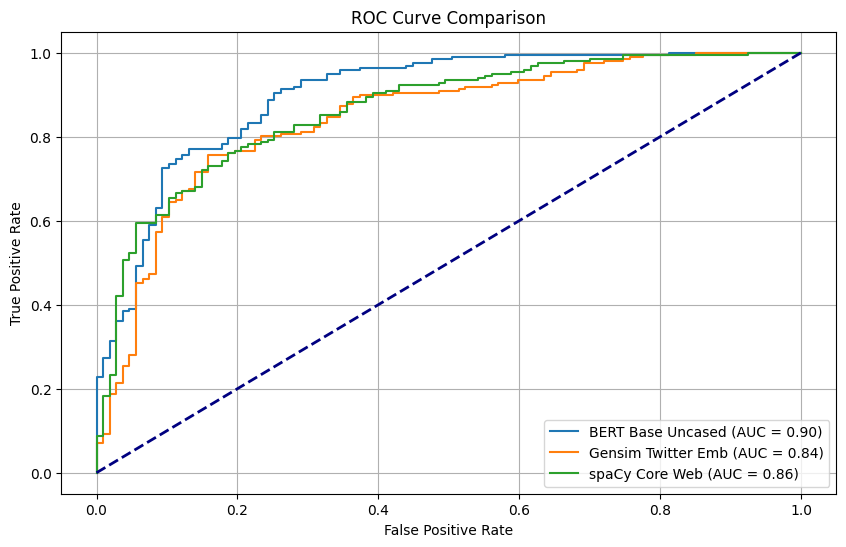

In [58]:


# Gather the ROC curve data for each model
roc_curves = [
    {"Model": "BERT Base Uncased", "FPR": fprs_bert_final, "TPR": tprs_bert_final, "AUC": roc_auc_bert_final},
    {"Model": "Gensim Twitter Emb", "FPR": fprs_twitter, "TPR": tprs_twitter, "AUC": roc_auc_twitter},
    {"Model": "spaCy Core Web", "FPR": fprs_spacy, "TPR": tprs_spacy, "AUC": roc_auc_spacy},

    # Add similar lines for any other models you have
]

# Create a plot with ROC curves
plt.figure(figsize=(10, 6))

for roc_curve_data in roc_curves:
    plt.plot(roc_curve_data["FPR"], roc_curve_data["TPR"], label=f'{roc_curve_data["Model"]} (AUC = {roc_curve_data["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [63]:

# Updated pipeline with StandardScaler
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Define the hyperparameters to search for the SVM
param_grid_svm = {
    'svc__kernel': ['poly', 'linear','rbf'],
    'svc__gamma': [0.1, 0.5, 1],
    'svc__C': [0.01, 0.05],
    'svc__degree': [4, 6],
    'svc__coef0': [3,5,7]
}


# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1, error_score='raise')

# Run the grid search on the BERT embeddings
grid_search_svm.fit(X_train_bert, y_train)

# After fitting, get the best estimator and parameters
best_model_svm = grid_search_svm.best_estimator_
print("Best hyperparameters:", grid_search_svm.best_params_)

# Evaluate the model on the test set
test_predictions_svm = best_model_svm.predict(X_test_bert)
val_acc_svm = accuracy_score(y_test, test_predictions_svm)
print(f"Validation Accuracy with Best Parameters: {val_acc_svm:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters: {'svc__C': 0.01, 'svc__coef0': 3, 'svc__degree': 4, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Validation Accuracy with Best Parameters: 0.8618


## Random Forest classifier

In [67]:
# Create a pipeline with the Random Forest classifier
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())

])

# Define the hyperparameters to search
param_grid_rf = {
    'rf__n_estimators': [500, 700],
    'rf__max_depth': [15, 20],
    'rf__min_samples_split': [15,20],
    'rf__min_samples_leaf': [7, 10]
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Run the grid search on the BERT embeddings
grid_search_rf.fit(X_train_bert, y_train)

# After fitting, get the best estimator and parameters
best_model_rf = grid_search_rf.best_estimator_
print("Best hyperparameters:", grid_search_rf.best_params_)

# Evaluate the model on the test set
test_predictions_rf = best_model_rf.predict(X_test_bert)
val_acc_rf = accuracy_score(y_test, test_predictions_rf)
print(f"Validation Accuracy with Best Parameters: {val_acc_rf:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 7, 'rf__min_samples_split': 15, 'rf__n_estimators': 500}
Validation Accuracy with Best Parameters: 0.8125


## XGBoost classifier

In [68]:
# Create a pipeline with the XGBoost classifier
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Define the hyperparameters to search
param_grid = {
    'xgb__n_estimators': [100],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Run the grid search on the BERT embeddings
grid_search.fit(X_train_bert, y_train)

# After fitting, get the best estimator and parameters
best_model_xgb = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
test_predictions_xgb = best_model_xgb.predict(X_test_bert)
val_acc_xgb = accuracy_score(y_test, test_predictions_xgb)
print(f"Validation Accuracy with Best Parameters: {val_acc_xgb:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Validation Accuracy with Best Parameters: 0.8586


## Summary of classifiers model evaluation parameters

In [71]:
# Initialize a list to store model names and their corresponding metrics
model_metrics = []

# Define the models and their predictions
models = {
    "BERT XG Boost": (X_test_bert, test_predictions_xgb),
    "BERT SVM": (X_test_bert, test_predictions_svm),
    "BERT Optimised Log Reg": (X_test_bert, predictions_bert_final),
    "BERT Random Forest": (X_test_bert, test_predictions_rf),
}

# Iterate through the models and calculate metrics
for model_name, (X_test, predicted) in models.items():
    accuracy = accuracy_score(y_test, predicted)
    precision_scores = precision_score(y_test, predicted, average=None)
    recall_scores = recall_score(y_test, predicted, average=None)
    f1_scores = f1_score(y_test, predicted, average=None)
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)
    macro_f1 = np.mean(f1_scores)

    model_metric = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Class 1 Precision": precision_scores[1],
        "Class 1 Recall": recall_scores[1],
        "Class 1 F1": f1_scores[1],
        "Class 0 Precision": precision_scores[0],
        "Class 0 Recall": recall_scores[0],
        "Class 0 F1": f1_scores[0],
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1 Score": macro_f1,
    }

    model_metrics.append(model_metric)

# Create a summary DataFrame
summary_df = pd.DataFrame(model_metrics)

# Display the summary DataFrame
summary_df


,Model,Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 0 Precision,Class 0 Recall,Class 0 F1,Macro Precision,Macro Recall,Macro F1 Score
0,BERT XG Boost,0.858553,0.863208,0.928934,0.894866,0.847826,0.728972,0.783920,0.855517,0.828953,0.839393
1,BERT SVM,0.861842,0.885572,0.903553,0.894472,0.815534,0.785047,0.800000,0.850553,0.844300,0.847236
2,BERT Optimised Log Reg,0.865132,0.848214,0.964467,0.902613,0.912500,0.682243,0.780749,0.880357,0.823355,0.841681
3,BERT Random Forest,0.812500,0.789256,0.969543,0.870159,0.903226,0.523364,0.662722,0.846241,0.746454,0.766441


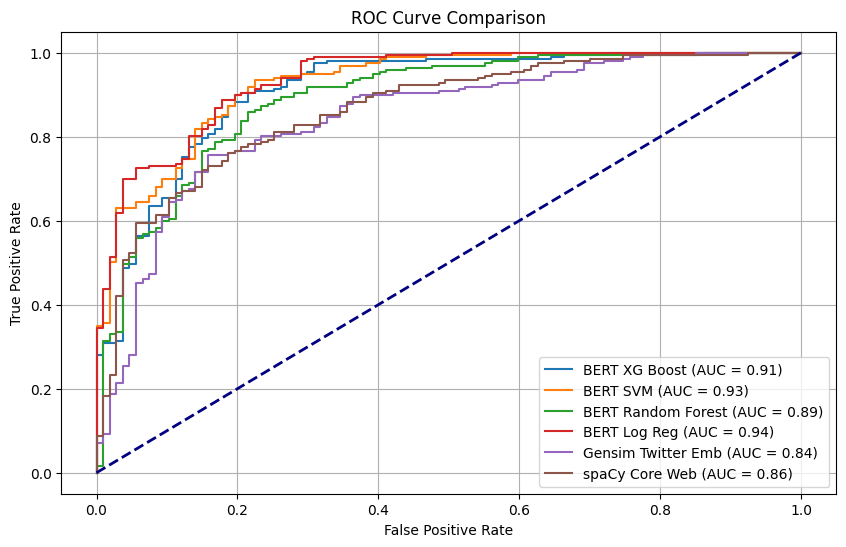

In [98]:

# Obtain probability scores for the positive class for each model
prob_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
scores_svm = best_model_svm.decision_function(X_test)
prob_rf = best_model_rf.predict_proba(X_test)[:, 1]
prob_bert_final = best_classifier_bert.predict_proba(X_test_bert)[:, 1]

# Calculate ROC curve data for each model
fprs_xgb, tprs_xgb, _ = roc_curve(y_test, prob_xgb)
roc_auc_xgb = auc(fprs_xgb, tprs_xgb)

fprs_svm, tprs_svm, _ = roc_curve(y_test, scores_svm)
roc_auc_svm = auc(fprs_svm, tprs_svm)

fprs_rf, tprs_rf, _ = roc_curve(y_test, prob_rf)
roc_auc_rf = auc(fprs_rf, tprs_rf)

fprs_bert_final, tprs_bert_final, _ = roc_curve(y_test, prob_bert_final)
roc_auc_bert_final = auc(fprs_bert_final, tprs_bert_final)

# Gather the ROC curve data for each model
roc_curves = [
    {"Model": "BERT XG Boost", "FPR": fprs_xgb, "TPR": tprs_xgb, "AUC": roc_auc_xgb},
    {"Model": "BERT SVM", "FPR": fprs_svm, "TPR": tprs_svm, "AUC": roc_auc_svm},
    {"Model": "BERT Random Forest", "FPR": fprs_rf, "TPR": tprs_rf, "AUC": roc_auc_rf},
    {"Model": "BERT Log Reg", "FPR": fprs_bert_final, "TPR": tprs_bert_final, "AUC": roc_auc_bert_final},
    {"Model": "Gensim Twitter Emb", "FPR": fprs_twitter, "TPR": tprs_twitter, "AUC": roc_auc_twitter},
    {"Model": "spaCy Core Web", "FPR": fprs_spacy, "TPR": tprs_spacy, "AUC": roc_auc_spacy}
]

# Create a plot with ROC curves
plt.figure(figsize=(10, 6))
for roc_curve_data in roc_curves:
    plt.plot(roc_curve_data["FPR"], roc_curve_data["TPR"], label=f'{roc_curve_data["Model"]} (AUC = {roc_curve_data["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
best_classifier_bert =

In [99]:
import pickle

# Specify the filename for the pickle file
pickle_filename = "bert_optimised_log_reg_model.pkl"

# Pickle the model
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_classifier_bert, file)

print(f"Model saved as {pickle_filename}")


Model saved as bert_optimised_log_reg_model.pkl
